In [16]:
%matplotlib inline
import random
import glob
import os
from PIL import Image
import torch
import torchvision
from torch.autograd import Variable
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from util.util import load_opt

def show(img, show=True):
    npimg = img.numpy()
    npimg = ((npimg / 2.0) + 0.5) * 255.0
    npimg = npimg.astype(np.uint8)
    if show:
        plt.figure(figsize = (10,10))
        plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    return Image.fromarray(npimg.transpose((1,2,0)))

import util.util as util
from models import networks
from options.test_options import TestOptions

def load_network_with_path(network, network_label, epoch_label='latest', path='./checkpoints/danbooru_celeba_cyclegan/'):
    save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
    save_path = os.path.join(path, save_filename)
    network.load_state_dict(torch.load(save_path))

def get_trans(crop=None, size=None):
    transform_list_show = []
    transform_list = []
    if crop is not None:
        opt.loadSize = crop
    if size is not None:
        opt.fineSize = size
    osize = [opt.loadSize, opt.loadSize]
    transform_list_show += [transforms.Scale(osize, Image.BICUBIC),
                       transforms.RandomCrop(opt.fineSize),
                       transforms.ToTensor()]
    img_show = transforms.Compose(transform_list_show)
    transform_list = transform_list_show + [transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))]
    img_pre = transforms.Compose(transform_list)
    return img_show, img_pre    

def get_idtrans(crop=None, size=None):
    transform_list_show = []
    transform_list = []
    transform_list_show += [transforms.ToTensor()]
    img_show = transforms.Compose(transform_list_show)
    transform_list = transform_list_show + [transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))]
    img_pre = transforms.Compose(transform_list)
    return img_show, img_pre   

def to_input(img, trans, size):
    img = trans(img)
    input_ = img.view(-1, 3, size, size)
    real = Variable(input_.cuda(7))
    return real

def test_img(img, net, trans, size=128, eval_mode=True, bn_eval=False, drop_eval=True):
    img = trans(img)
    input_ = img.unsqueeze(0)
    real = Variable(input_.cuda(7))
    set_eval(net, bn_eval, drop_eval)
    fake = net.forward(real)
    return fake

def get_stack_nets(path, which_epoch = 'latest'):
    gpu_ids = [0]
    Tensor = torch.cuda.FloatTensor
    opt = load_opt(path)
    netG_A = networks.define_G(opt.input_nc, opt.output_nc,
                            opt.ngf, opt.which_model_netG, opt.norm, False, opt.init_type, 
                            gpu_ids, n_upsampling=3, opt=opt)
    netG_B = networks.define_G(opt.output_nc, opt.input_nc,
                            opt.ngf, opt.which_model_netG, opt.norm, False, opt.init_type, 
                            gpu_ids, n_upsampling=3, opt=opt)
    netG_A_pre = networks.define_G(opt.input_nc, opt.output_nc,
                            opt.ngf, opt.which_model_netG, opt.norm, False, opt.init_type, 
                            gpu_ids, n_downsampling=3, opt=opt)
    netG_B_pre = networks.define_G(opt.output_nc, opt.input_nc,
                            opt.ngf, opt.which_model_netG, opt.norm, False, opt.init_type, 
                            gpu_ids, n_downsampling=3, opt=opt)

    load_network_with_path(netG_A,  'G_A', which_epoch, path)
    load_network_with_path(netG_B,  'G_B', which_epoch, path)
    load_network_with_path(netG_A_pre,  'G_A_pre', which_epoch, path)
    load_network_with_path(netG_B_pre,  'G_B_pre', which_epoch, path)
        
    netG_A.cuda()
    netG_B.cuda()
    netG_A_pre.cuda()
    netG_B_pre.cuda()
    
    return {'A':netG_A, 'B':netG_B, 'A_pre':netG_A_pre, 'B_pre':netG_B_pre}

def get_stack_nets(path, which_epoch = 'latest', skip=True):
    gpu_ids = [0]
    Tensor = torch.cuda.FloatTensor
    opt = load_opt(path)
    opt.max_ngf = 256
    netG_A = networks.define_G(opt.input_nc if not skip else opt.input_nc * 2, opt.output_nc,
                            opt.ngf, opt.which_model_netG, opt.norm, not opt.no_dropout, opt.init_type, 
                            gpu_ids, n_upsampling=opt.n_upsample, opt=opt)
    netG_B = networks.define_G(opt.input_nc if not skip else opt.input_nc * 2, opt.input_nc,
                            opt.ngf, opt.which_model_netG, opt.norm, not opt.no_dropout, opt.init_type, 
                            gpu_ids, n_upsampling=opt.n_upsample, opt=opt)
    if 'pre_path' in vars(opt).keys():
        opt_pre = load_opt(opt.pre_path)
        netG_A_pre = networks.define_G(opt.input_nc, opt.output_nc,
                                opt_pre.ngf, opt_pre.which_model_netG, opt_pre.norm, not opt_pre.no_dropout, opt_pre.init_type, 
                                gpu_ids, n_downsampling=3, opt=opt_pre)
        netG_B_pre = networks.define_G(opt.output_nc, opt.input_nc,
                                opt_pre.ngf, opt.which_model_netG, opt_pre.norm, not opt_pre.no_dropout, opt_pre.init_type, 
                                gpu_ids, n_downsampling=3, opt=opt_pre)
    else:
        opt.pre_path = ''
        netG_A_pre = networks.define_G(opt.input_nc, opt.output_nc,
                            opt.ngf, opt.which_model_netG, opt.norm, False, opt.init_type, 
                            gpu_ids, n_downsampling=3, opt=opt)
        netG_B_pre = networks.define_G(opt.output_nc, opt.input_nc,
                            opt.ngf, opt.which_model_netG, opt.norm, False, opt.init_type, 
                            gpu_ids, n_downsampling=3, opt=opt)

    load_network_with_path(netG_A,  'G_A', which_epoch, path)
    load_network_with_path(netG_B,  'G_B', which_epoch, path)
    load_network_with_path(netG_A_pre,  'G_A_pre', which_epoch, path if opt.pre_path == '' else opt.pre_path)
    load_network_with_path(netG_B_pre,  'G_B_pre', which_epoch, path if opt.pre_path == '' else opt.pre_path)
        
    netG_A.cuda()
    netG_B.cuda()
    netG_A_pre.cuda()
    netG_B_pre.cuda()
    
    return {'A':netG_A, 'B':netG_B, 'A_pre':netG_A_pre, 'B_pre':netG_B_pre}

def get_nets(path, which_epoch = 'latest'):
    gpu_ids = [0]
    Tensor = torch.cuda.FloatTensor
    opt = load_opt(path)
    opt.not_caffe = True
    if 'caffe' in path or 'top' in path:
        opt.not_caffe = False
    netG_A = networks.define_G(opt.input_nc, opt.output_nc,
                                  opt.ngf, opt.which_model_netG,
                                  opt.norm,  not opt.no_dropout, opt.init_type,
                                  gpu_ids, opt=opt)
    load_network_with_path(netG_A, 'G_A', which_epoch, path)
    
    netG_B = networks.define_G(opt.input_nc, opt.output_nc,
                                  opt.ngf, opt.which_model_netG,
                                  opt.norm,  not opt.no_dropout, opt.init_type,
                                  gpu_ids, opt=opt)
    load_network_with_path(netG_B, 'G_B', which_epoch, path)
    
    netG_A.cuda(7)
    netG_B.cuda(7)
    
    return {'A':netG_A, 'B':netG_B}

def get_nets_dis(path, which_epoch = 'latest'):
    gpu_ids = [0]
    Tensor = torch.cuda.FloatTensor
    opt = load_opt(path)
    opt.caffe=False
    netD_A = networks.define_D(opt.output_nc, opt.ndf,
                                    opt.which_model_netD,
                                    opt.n_layers_D, opt.norm, False, opt.init_type, gpu_ids, opt=opt)
    netD_B = networks.define_D(opt.input_nc, opt.ndf,
                                    opt.which_model_netD,
                                    opt.n_layers_D, opt.norm, False, opt.init_type, gpu_ids, opt=opt)
    load_network_with_path(netD_A, 'D_A', which_epoch, path)
    load_network_with_path(netD_B, 'D_B', which_epoch, path)
    
    netD_A.cuda()
    netD_B.cuda()
    
    return {'A':netD_A, 'B':netD_B}

def set_eval(net, bn=True, drop=True):
    if isinstance(net, torch.nn.Dropout):
        net.training = not drop
    elif  isinstance(net, torch.nn.BatchNorm2d) or  isinstance(net, torch.nn.InstanceNorm2d):
        net.training = not bn
    else:
        net.training = False
    for i in net.children():
        set_eval(i, bn, drop)

opt = TestOptions().parse()
opt.nThreads = 1   # test code only supports nThreads = 1
opt.batchSize = 1  # test code only supports batchSize = 1
opt.serial_batches = True  # no shuffle
opt.no_flip = True  # no flip

------------ Options -------------
alpha_gate: 
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
dataroot: ./datasets/danbooru_celeba
dataset_mode: unaligned
f: /run/user/1001/jupyter/kernel-7f9190ae-9d6a-441e-b391-a0b9bdbd73c3.json
feat_len_D: 256
feat_only: False
fineSize: 256
gpu_ids: [0]
how_many: inf
idt: False
img_2ngf: False
img_only: False
init_type: xavier
input_nc: 3
isTrain: False
keep_pre: False
kw: 3
legacy_D: False
loadSize: 286
load_pre: False
lr_pre: 2e-05
max_dataset_size: inf
max_ngf: 256
model: cycle_gan
nThreads: 2
n_downsample: 2
n_layers_D: 3
n_layers_D_pre: 3
n_resblocks: 9
n_upsample: 2
name: experiment_name
ndf: 64
ngf: 64
no_dropout: False
no_flip: False
norm: batch
not_caffe: False
not_mono_gate: False
ntest: inf
one_out: False
out7: False
out_num: 3
output_nc: 3
phase: test
pre_path: 
resize_or_crop: resize_and_crop
results_dir: ./results/
serial_batches: False
shallow_resblock: False
shift_alpha: False
simple_block: False
skip: False
skip_feat:

In [287]:
B_paths = glob.glob('/data2/minjunli/celeba/celeba_no_male/*')
# B_paths = glob.glob('/data2/minjunli/prj/anime/fake_detect/haozhi_val/*')
img_id_show, img_id_pre = get_idtrans()
img_show_128, img_pre_128 = get_trans(128, 128)

In [203]:
net_0 = get_nets('/data2/minjunli/outbox/Get_AisCelSelf_128_d3_aff_gp2p5_caffe_3/')
net_1 = get_nets('../trans/Get_AisCel_128_d4_gpreweight_0/')
net_2 = get_nets('../trans/Get_AisCel_128_d4_gpreweight_1/')
net_3 = get_nets('./checkpoints/Get_Cel_Ali_Cln_128_def_long/')
net_4 = get_nets('./checkpoints/Get_Ais_128_d4_gpreweight_0/')
net_5 = get_nets('./checkpoints/Get_Ais_128_d4_gpreweight_1/')
net_6 = get_nets('../trans/Get_Cel_Ali_Cln_128_d4_gpreweight_1/')

initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]


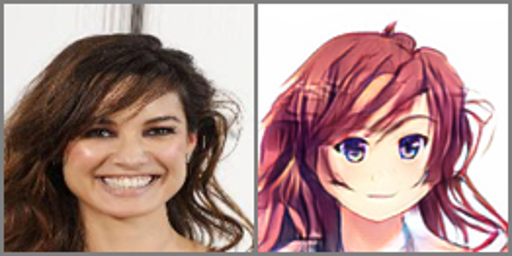

In [409]:
B_p = random.choice(B_paths)
# B_p = '/data2/minjunli/celeba/original/img_celeba/032085.jpg'
B_cut_p = os.path.join('/data2/minjunli/celeba/img_align_celeba/', B_p.split('/')[-1])
toshow = [img_pre_128(Image.open(B_cut_p).resize((128,128),Image.BICUBIC)), ]
for i in [2]:#range(0,7):
    _ = test_img(Image.open(B_cut_p), eval('net_%d[\'B\']'%i), img_pre_128, 0, bn_eval=False, drop_eval=True)
    toshow.append(_.data[0].cpu())
show(torchvision.utils.make_grid(toshow),show=False).resize((512,256), Image.BICUBIC)

In [285]:
from IPython.html.widgets import interact
from PIL import Image
from PIL import ImageOps

def resize_plot(x=0.42, d=0.81, rot=-4):
    B_ = Image.open(B_p).convert('RGB')#.crop((1445,0,3666,2028))
    max_base_width = 512
    wpercent = (max_base_width/float(B_.size[0]))
    hsize = int((float(B_.size[1])*float(wpercent)))
    B_1 = B_.resize((max_base_width,hsize), Image.BICUBIC).rotate(0)
    B_2 = B_1
    if rot!= 0:
        B_2_orig = B_2
        np_im = np.array(B_2)
        pad_type = 'edge'
        pad_size = max(B_2.size[0], B_2.size[1]) / 2
        tmp_im = Image.fromarray(np.rot90(np.array([np.pad(np_im[:,:,0], pad_size, pad_type), \
                                  np.pad(np_im[:,:,1], pad_size, pad_type), \
                                  np.pad(np_im[:,:,2], pad_size, pad_type)]).T, 3))
        B_2 = ImageOps.mirror(tmp_im)
        B_2 = B_2.rotate(rot, Image.BICUBIC)
        B_2 = B_2.crop((pad_size, pad_size, pad_size+B_2_orig.size[0], pad_size+B_2_orig.size[1]))
    B_2 = B_2.resize((int((B_1.size[0])*x),int((B_1.size[1])*(x*d))), Image.BICUBIC)
    fake_A_1 = test_img(B_2, net_2['B'], img_id_pre, 0, eval_mode=True)
    B_2_show = Image.new('RGB', (fake_A_1.shape[-1], fake_A_1.shape[-2]), (0,0,0))
    print B_2.size, B_2_show.size
    B_2_show.paste(B_2, (0,0))#B_2.getbbox())
    y = show(torchvision.utils.make_grid([img_id_pre(B_2_show),fake_A_1.data[0].cpu()]), show=False)
    out_width = 1024
    wpercent = (out_width/float(y.size[0]))
    hsize = int((float(y.size[1])*float(wpercent)))
    return y.resize((out_width,hsize), Image.BICUBIC)

interact(resize_plot, x=(0,1,0.001), d=(0.5,1.2,0.001), rot=(-30,30,1))

<function __main__.resize_plot>

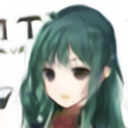